In [179]:
#Import usefull libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
!pip install tld
!pip install pandas pyarrow
from tld import get_tld
import json
import bz2
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Disable some pandas warnings we don't need
pd.options.mode.chained_assignment = None

## 1 - Initial analysis of the cropped Quotebank dataset

We have filtered out all the rows corresponding to quotes that did not contain any of the keywords related to gun control. The remaining rows have been added to a new file: 'quotes-cropped.json', which will be one of our main datasets for this project. It is much more reasonnable in size (550 Mo) than the full Quotebank dataset. This will allow us to work with Jupyter lab with all the data we need.

Since we only consider those quotes from American online newspapers, we should be able to determine which country the websites
belong to.
In order to reach this target, we choose to use a new dataset which contains country-website pairs.

In [156]:
def get_domain(url):
    res = get_tld(url, as_object=True)
    return res.domain

new_src = pd.read_csv('data/news.txt', delimiter="\t", header=None, encoding = "ISO-8859-1")
new_src.columns=['id','unknown','date','country','media','website','title']
new_src['domain']=new_src.apply(lambda x : get_domain(x['website']),axis=1)
new_src.drop_duplicates(inplace=True, subset=['domain'], keep='first')
new_src.head()

id  unknown      date country                media  \
0  11241      397  13-01-06      US               Kotaku   
1  11242      757  13-01-06      US       Michigan Radio   
2  11243      755  13-01-06      US  New York Daily News   
3  11244     1677  13-01-06      US       OregonLive.com   
4  21242      794  13-01-11      US         Ars Technica   

                                             website  \
0  http://kotaku.com/5973495/author-of-the-warrio...   
1  http://michiganradio.org/post/thats-what-they-...   
2  http://www.nydailynews.com/life-style/eats/bes...   
3  http://www.oregonlive.com/performance/index.ss...   
4  http://arstechnica.com/gadgets/2013/01/ask-ars...   

                                               title         domain  
0  Author of The Warriors, Cult Film Adapted to H...         kotaku  
1  That's What They Say: Dialect Society chooses ...  michiganradio  
2                        Best of New York: Croissant    nydailynews  
3  Reflecting on a quarter-century of growth in P...     oregonlive  
4  Ask Ars: Does Facebook auto-delete content aft...    arstechnica

Operating on the file quotes-cropped, we assign to each quotation a new field 'country' according to the media which quotes
the sentence.


In [ ]:
path_to_out = 'data/quotes-cropped-with-country.json.bz2'
with bz2.open("data/quotes-cropped.json.bz2", 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
        for instance in s_file:
                instance = json.loads(instance) # loading a sample
                urls = instance['urls'] # extracting list of links 
                instance['country']=np.nan
                for url in urls:
                    domain=get_domain(url)
                    if len(new_src[new_src['domain']==domain])>=1:
                        instance['country']=new_src[new_src['domain']==domain]['country'].item()
                        break
                d_file.write((json.dumps(instance)+'\n').encode('utf-8'))

In [236]:
# New dataframe with the data ('quotes-cropped.jspon')
with bz2.open("data/quotes-cropped-with-country.json.bz2", 'rb') as s_file: 
    df_original = pd.read_json(s_file, lines=True)
df_original.head()

quoteID                                          quotation  \
0  2015-11-17-031545  However, that had nothing to do with the blast...   
1  2015-12-29-000719  91 percent of suspected terrorists who attempt...   
2  2015-06-15-000921  a powerful and compelling motive to lie about ...   
3  2015-12-08-003771  After the failure of the U.S. Congress to pass...   
4  2015-01-09-024195  I got back inside and then they started shooti...   

          speaker                                               qids  \
0  Dawood Ibrahim                                          [Q553191]   
1  Patrick Murphy  [Q17418821, Q21170773, Q2224935, Q23418906, Q3...   
2            None                                                 []   
3      Roy Cooper                    [Q16106910, Q7372694, Q7372695]   
4   Herman Torres                                        [Q18285204]   

                 date  numOccurrences  \
0 2015-11-17 13:32:58               3   
1 2015-12-29 15:42:57               4   
2 2015-06-15 21:39:12               1   
3 2015-12-08 16:15:05               1   
4 2015-01-09 03:39:35               1   

                                              probas  \
0  [[Dawood Ibrahim, 0.6072], [None, 0.338], [San...   
1  [[Patrick Murphy, 0.8398], [None, 0.1579], [Je...   
2  [[None, 0.7388], [Joseph Thompson, 0.2313], [A...   
3  [[Roy Cooper, 0.928], [None, 0.0574], [Frank P...   
4          [[Herman Torres, 0.9218], [None, 0.0782]]   

                                                urls phase country  
0  [http://www.newindianexpress.com/nation/Part-o...     E      IN  
1  [http://politifact.com/florida/statements/2015...     E      US  
2  [http://dailylocal.com/general-news/20150613/n...     E    None  
3  [http://digtriad.com/story/news/2015/12/08/sho...     E    None  
4  [http://www.wesh.com/news/orange-county-sherif...     E      US

In [237]:
df_original=df_original[df_original['country']=='US']
df_original.head()

quoteID                                          quotation  \
1   2015-12-29-000719  91 percent of suspected terrorists who attempt...   
4   2015-01-09-024195  I got back inside and then they started shooti...   
20  2015-11-26-034388  I'm letting him try to find it for himself. He...   
24  2015-07-30-026870  He described a shooting that looked nothing li...   
26  2015-08-21-026312  He was not armed, he did not have a gun, our i...   

               speaker                                               qids  \
1       Patrick Murphy  [Q17418821, Q21170773, Q2224935, Q23418906, Q3...   
4        Herman Torres                                        [Q18285204]   
20         Byron Scott                                          [Q538009]   
24  Lawrence Middleton                                        [Q16091535]   
26                None                                                 []   

                  date  numOccurrences  \
1  2015-12-29 15:42:57               4   
4  2015-01-09 03:39:35               1   
20 2015-11-26 18:51:56               3   
24 2015-07-30 05:00:00              12   
26 2015-08-21 20:54:00               2   

                                               probas  \
1   [[Patrick Murphy, 0.8398], [None, 0.1579], [Je...   
4           [[Herman Torres, 0.9218], [None, 0.0782]]   
20  [[Byron Scott, 0.8244], [None, 0.1685], [Kobe ...   
24  [[Lawrence Middleton, 0.8756], [None, 0.1233],...   
26  [[None, 0.8635], [Sam Dotson, 0.1133], [Michae...   

                                                 urls phase country  
1   [http://politifact.com/florida/statements/2015...     E      US  
4   [http://www.wesh.com/news/orange-county-sherif...     E      US  
20  [http://www.latimes.com/sports/lakers/la-sp-la...     E      US  
24  [http://feeds.latimes.com/~r/features/books/~3...     E      US  
26  [http://www.latimes.com/nation/la-na-black-mis...     E      US

We will start by plotting the number of quotes containing at least one of our keywords over time (i.e. between 2015 and 2020). Even though some quotes will be irrelevant (e.g. "we were **shooting** a movie"), we assume the distribution of these irrelevant quotes to be close to uniform for the moment. For the final project, we plan to be using Machine Learning algorithms to better select the data from the Quotebank dataset (instead of the keywords), choosing only quotes who have a high probability to be relevant.

Our plot should therefore give a good first impression on how much people/the media has been speaking about gun control during these five years.

In [238]:
# Keep only the columns that we need for our initial analysis
df = df_original[['date','quotation']]

# Convert data column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort dataframe by date
df = df.sort_values(by=['date'])

df.head()

date                                          quotation
55989  2015-01-01 00:40:01  If you see someone shooting, tell them it's no...
52336  2015-01-01 00:40:01                    No celebratory gunfire tonight,
105372 2015-01-01 00:40:01  When my 9-year-old daughter looks in my face a...
61668  2015-01-01 00:40:01  When you're impared in any way, you should nev...
95839  2015-01-01 00:40:01  The fundamental handling of safe firearms is k...

Now that we have sorted the dataframe by date, we can move on to the plot.

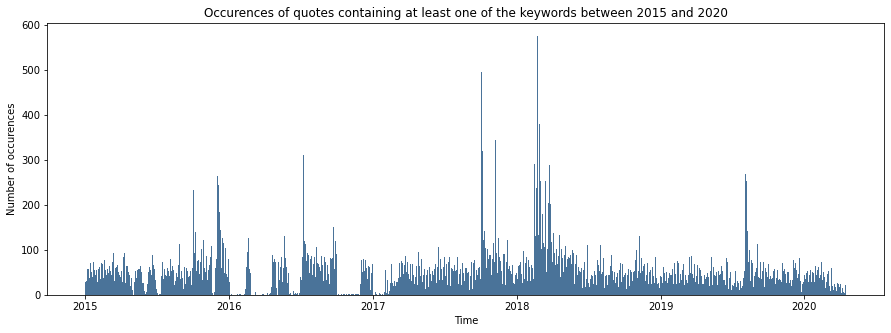

In [239]:
# Plotting number of quotes that contain keywords on the timeframe of the dataset
plt.figure(figsize=(15,5))

plt.hist(df['date'], bins=2000, color='#4a7399')

plt.title('Occurences of quotes containing at least one of the keywords between 2015 and 2020')
plt.xlabel('Time')
plt.ylabel('Number of occurences')
plt.show()

This histogram gives a good idea of how much people have been speaking of guns/firearms/shootings in the last 5 years in the media. **But it has a major flaw**: each quote has the same "weight" (one quote accounts for one occurence). But some quotes occure more often then others ('numOccurences' colum in the dataframe). We should take this extra information into account if we want a better view on the data.

We will now define a new dataframe that contains the number of quotes (multiplied by their respective occurences) for each day that contain at least one of the keywords.

In [240]:
# Define a new dataframe for this specific study
df = df_original[['date','numOccurrences']]

# Remove hour from the date
df['date'] = df['date'].dt.date

# Group by date and sum number of occurences
df = df.groupby(['date']).sum()
df = df.reset_index()

# Convert data column back to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort dataframe by date
df = df.sort_values(by=['date'])

df.head()

date  numOccurrences
0 2015-01-01              91
1 2015-01-02             332
2 2015-01-03             110
3 2015-01-04             121
4 2015-01-05             408

We now have our desired dataframe: one row is one day, and for each day we have the number of quotes (multiplied by their occurences) that contain at least a keyword.

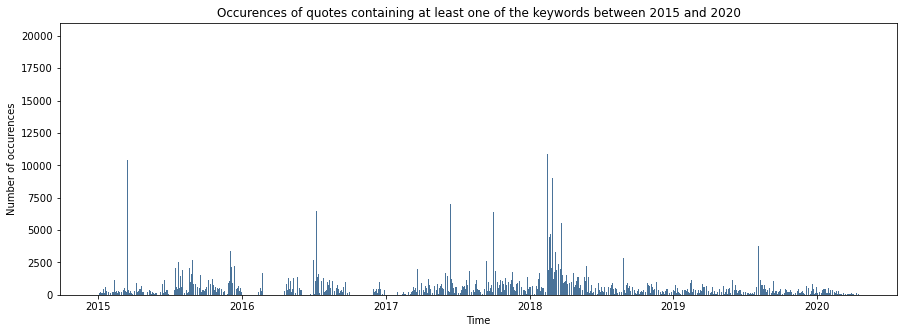

In [241]:
# Plotting number of quotes that contain keywords on the timeframe of the dataset
plt.figure(figsize=(15,5))

plt.bar(df['date'],df['numOccurrences'],color='#4a7399')
plt.title('Occurences of quotes containing at least one of the keywords between 2015 and 2020')
plt.xlabel('Time')
plt.ylabel('Number of occurences')
plt.ylim(0,21000)
plt.show()

We have cleared a possible source of error out of the way. We will be using this new dataframe in the rest of the analysis. If we happen to need more information about the quotes that were said on a specific date, we can always switch back to looking for quotes on that specific date in the original dataframe (from the "cropped" Quotebank).

In [242]:
# We will use this data in comparitive plots in part 3
data1 = df[['date','numOccurrences']]

In the end, we see that this is plot is extremly similar to what we have obtained in the previous histogram. This is probably what data science is about sometimes... But at least we have cleared a possible source of error out of the way. We will be using this specific dataframe in the rest of the analysis.

## 2 - Initial analysis of the speaker attributes dataset

We have loaded the speaker attributes dataset to extract additional information about quotations' speakers, for statistic purpose in case of need.

In [193]:
speaker_attributes=pd.read_parquet('data/speaker_attributes.parquet')

In [194]:
speaker_attributes.head()

aliases            date_of_birth  \
0  [Washington, President Washington, G. Washingt...  [+1732-02-22T00:00:00Z]   
1  [Douglas Noel Adams, Douglas Noël Adams, Dougl...  [+1952-03-11T00:00:00Z]   
2      [Paul Marie Ghislain Otlet, Paul Marie Otlet]  [+1868-08-23T00:00:00Z]   
3  [George Walker Bush, Bush Jr., Dubya, GWB, Bus...  [+1946-07-06T00:00:00Z]   
4  [Velázquez, Diego Rodríguez de Silva y Velázqu...  [+1599-06-06T00:00:00Z]   

      nationality      gender   lastrevid ethnic_group US_congress_bio_ID  \
0  [Q161885, Q30]  [Q6581097]  1395141751         None            W000178   
1          [Q145]  [Q6581097]  1395737157   [Q7994501]               None   
2           [Q31]  [Q6581097]  1380367296         None               None   
3           [Q30]  [Q6581097]  1395142029         None               None   
4           [Q29]  [Q6581097]  1391704596         None               None   

                                          occupation      party  \
0  [Q82955, Q189290, Q131512, Q1734662, Q294126, ...  [Q327591]   
1  [Q214917, Q28389, Q6625963, Q4853732, Q1884422...       None   
2  [Q36180, Q40348, Q182436, Q1265807, Q205375, Q...       None   
3  [Q82955, Q15982858, Q18814623, Q1028181, Q1408...   [Q29468]   
4                                         [Q1028181]       None   

  academic_degree     id              label  \
0            None    Q23  George Washington   
1            None    Q42      Douglas Adams   
2            None  Q1868         Paul Otlet   
3            None   Q207     George W. Bush   
4            None   Q297    Diego Velázquez   

                                candidacy  type                    religion  
0                      [Q698073, Q697949]  item                   [Q682443]  
1                                    None  item                        None  
2                                    None  item                        None  
3  [Q327959, Q464075, Q3586276, Q4450587]  item  [Q329646, Q682443, Q33203]  
4                                    None  item                        None

Here we extract the attribute 'speaker' from Quotebank data.

In [196]:
df_speaker=df_original['speaker']
df_speaker.head()

1         Patrick Murphy
4          Herman Torres
20           Byron Scott
24    Lawrence Middleton
26                  None
Name: speaker, dtype: object

We have identified all speakers appearing in Quotebank dataset, and we have removed from speakers attribute dataset the rows which are not related to those speakers.

In [187]:
index=speaker_attributes.apply(lambda x: len(df_speaker[df_speaker==x['label']])>0 , axis=1)

In [198]:
speaker_attributes=speaker_attributes[index]
speaker_attributes.head()

Unnamed: 0                                            aliases  \
0           3  ['George Walker Bush' 'Bush Jr.' 'Dubya' 'GWB'...   
1           8  ['Neil Percival Young' 'Shakey' 'Godfather of ...   
2          14  ['Mary Louise Streep' 'Meryl Louise Streep' 'S...   
3          15                         ['Donald Franciszek Tusk']   
4          18  ['Namo' 'Modi' 'Narendra Bhai' 'Narendra Damod...   

               date_of_birth    nationality        gender   lastrevid  \
0  ['+1946-07-06T00:00:00Z']        ['Q30']  ['Q6581097']  1395142029   
1  ['+1945-11-12T00:00:00Z']  ['Q16' 'Q30']  ['Q6581097']  1395459626   
2  ['+1949-06-22T00:00:00Z']        ['Q30']  ['Q6581072']  1388232380   
3  ['+1957-04-22T00:00:00Z']        ['Q36']  ['Q6581097']  1390487039   
4  ['+1950-09-17T00:00:00Z']       ['Q668']  ['Q6581097']  1395415052   

              ethnic_group US_congress_bio_ID  \
0                      NaN                NaN   
1                      NaN                NaN   
2                      NaN                NaN   
3                      NaN                NaN   
4  ['Q1282294' 'Q6889284']                NaN   

                                          occupation                  party  \
0  ['Q82955' 'Q15982858' 'Q18814623' 'Q1028181' '...             ['Q29468']   
1  ['Q177220' 'Q488205' 'Q2526255' 'Q639669' 'Q18...                    NaN   
2  ['Q10800557' 'Q2259451' 'Q10798782' 'Q2405480'...             ['Q29552']   
3                               ['Q82955' 'Q201788']  ['Q156868' 'Q208242']   
4         ['Q82955' 'Q36180' 'Q7019111' 'Q10429346']             ['Q10230']   

  academic_degree     id           label  \
0             NaN   Q207  George W. Bush   
1             NaN   Q633      Neil Young   
2             NaN   Q873    Meryl Streep   
3             NaN   Q946     Donald Tusk   
4             NaN  Q1058   Narendra Modi   

                                           candidacy  type  \
0        ['Q327959' 'Q464075' 'Q3586276' 'Q4450587']  item   
1                                                NaN  item   
2                                                NaN  item   
3                                       ['Q2586050']  item   
4  ['Q63988227' 'Q63988919' 'Q16841231' 'Q1625196...  item   

                         religion  
0  ['Q329646' 'Q682443' 'Q33203']  
1                             NaN  
2                       ['Q7066']  
3                       ['Q9592']  
4                       ['Q9089']

In [192]:
speaker_attributes.to_csv('data/speaker.csv')

## 3 - Initial analysis of the "Mother Jone's" dataset

We have also proceeded to some initial analysis of the "Mother Jone's US Mass Shootings" dataset. Indeed, this dataset will give us some basic information about most shootings, such as: date, location, number of fatalities, number of injured, age of shooter, weapon type/legality...

In [230]:
# Reading the csv file
df = pd.read_csv('./Data/MassShootings.csv')

# Replace "-" by NaN in "age of shooter" column
df['age_of_shooter'] = df['age_of_shooter'].replace('-', np.nan).astype(float)

# Two new columns: location splitted into town and state
df[['town', 'state']] = df['location'].str.split(', ', expand = True)

# Convert date column to datetime format for better handling
df['date'] = pd.to_datetime(df['date'])

# Quotebank dataset is limited to years 2015-2020. Need to use same time span:
df = df.drop(df[df['date'].dt.year < 2015].index)
df = df.drop(df[df['date'].dt.year > 2020].index)

df.head()

case                 location       date  \
5  Springfield convenience store shooting    Springfield, Missouri 2020-03-16   
6                   Molson Coors shooting     Milwaukee, Wisconsin 2020-02-26   
7      Jersey City kosher market shooting  Jersey City, New Jersey 2019-12-10   
8           Pensacola Naval base shooting       Pensacola, Florida 2019-12-06   
9           Odessa-Midland shooting spree            Odessa, Texas 2019-08-31   

                                             summary  fatalities  injured  \
5  Joaquin S. Roman, 31, went on a rampage culmin...           4        0   
6  Anthony Ferrill, 51, an employee armed with tw...           5        0   
7  David N. Anderson, 47, and Francine Graham, 50...           4        3   
8  Ahmed Mohammed al-Shamrani, A Saudi Arabian mi...           3        8   
9  Seth A. Ator, 36, fired at police officers who...           7       25   

   total_victims location.1  age_of_shooter prior_signs_mental_health_issues  \
5              4  Workplace            31.0                                -   
6              5  Workplace            51.0                                -   
7              7      Other             NaN                                -   
8             11   Military             NaN                                -   
9             32      Other            36.0                              yes   

   ...         gender                                            sources  \
5  ...              M  https://www.kiro7.com/news/trending/ive-been-s...   
6  ...              M  https://www.jsonline.com/story/news/local/2020...   
7  ...  Male & Female  https://www.nytimes.com/2019/12/15/nyregion/je...   
8  ...              M  https://www.washingtonpost.com/national-securi...   
9  ...              M  https://www.washingtonpost.com/politics/5-kill...   

                               mental_health_sources sources_additional_age  \
5                                                  -                      -   
6                                                  -                      -   
7                                                  -                      -   
8                                                  -                      -   
9  https://www.nytimes.com/2019/09/02/us/texas-gu...                      -   

    latitude   longitude   type  year         town       state  
5  37.210432  -93.236860   Mass  2020  Springfield    Missouri  
6  43.044511  -87.962537   Mass  2020    Milwaukee   Wisconsin  
7  40.707363  -74.083609  Spree  2019  Jersey City  New Jersey  
8  30.364707  -87.288567   Mass  2019    Pensacola     Florida  
9  31.925974 -102.279600  Spree  2019       Odessa       Texas  

[5 rows x 26 columns]

In [231]:
df.dtypes

case                                        object
location                                    object
date                                datetime64[ns]
summary                                     object
fatalities                                   int64
injured                                      int64
total_victims                                int64
location.1                                  object
age_of_shooter                             float64
prior_signs_mental_health_issues            object
mental_health_details                       object
weapons_obtained_legally                    object
where_obtained                              object
weapon_type                                 object
weapon_details                              object
race                                        object
gender                                      object
sources                                     object
mental_health_sources                       object
sources_additional_age         

We notice that some of the entries for age of the shooter are not numbers. To perform further analysis, we will set all the values of this column as floats and replace '-' by NaN.

In [201]:
df['age_of_shooter'] = df['age_of_shooter'].replace('-', np.nan)
df['age_of_shooter'] = df['age_of_shooter'].astype(float)

To give us a first glimpse at the data, we can plot the fatalities per shooting accross time, as well as the distribution of the number of fatalities per shooting.

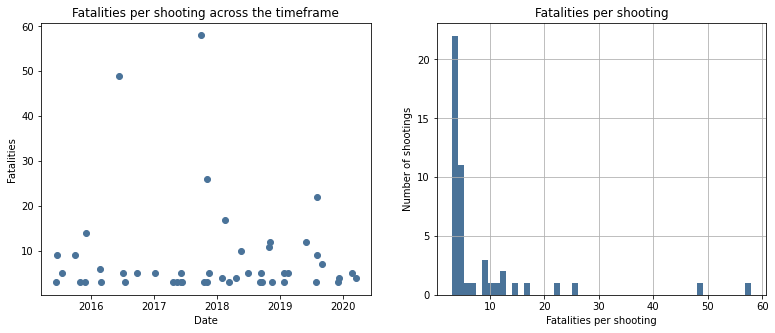

In [232]:
fig, ax = plt.subplots(1,2,figsize=(13,5))

# Plot shootings in (time, number of fatalities) format
ax[0].scatter(df['date'], df['fatalities'], color='#4a7399')
ax[0].set_title('Fatalities per shooting across the timeframe')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Fatalities');

# Plot the distribution of the number of fatalities
ax[1] = df['fatalities'].hist(bins=50, color='#4a7399')
ax[1].set_xlabel('Fatalities per shooting')
ax[1].set_ylabel('Number of shootings')
ax[1].set_title('Fatalities per shooting');

There isn't much data, but we can say it seems to follow a power law: most of the shootings have a small number of fatalities (<10), but some outliers are not unusual either, some shootings having over 40 fatalities.

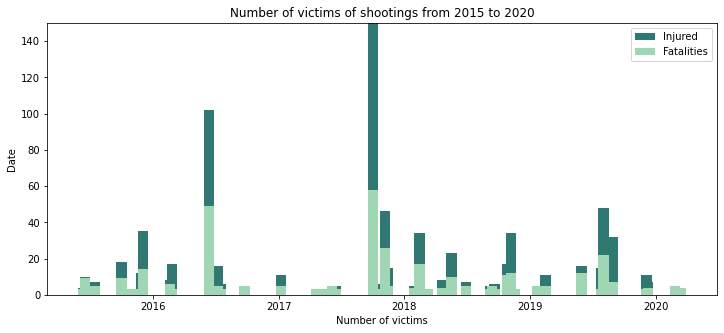

In [203]:
# The distribution of of fatalities, injured, total per month is plotted here
fig, ax = plt.subplots(figsize=(12, 5))
plt.bar(df['date'],df['total_victims'],width=30, color = '#317873')
plt.bar(df['date'],df['fatalities'],width=30, color = '#a0d6b4')
plt.title('Number of victims of shootings from 2015 to 2020')
plt.xlabel('Number of victims')
plt.ylabel('Date')
plt.ylim(top=150)
plt.legend(['Injured','Fatalities'])
plt.show()

There are many paramters to explore, and one of them is location of the event:

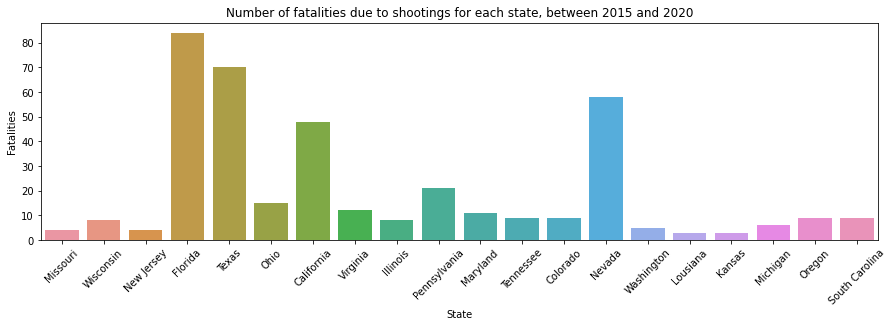

In [204]:
# Ploting the number of fatalities per state

fig, ax = plt.subplots(figsize=(15, 4))
ax = sns.barplot(y = df['fatalities'], x = df['state'], estimator = sum, ci = None)

ax.set_xlabel("State")
ax.set_ylabel("Fatalities")
ax.set_title("Number of fatalities due to shootings for each state, between 2015 and 2020")
plt.xticks(rotation=45)
plt.show()

With the above plot, we can clearly see that states have been very unequally affected by mass shootings. We can try to find some relevant correlations further on, such as average salary in the state, state political position (more of a 'blue state' or a 'red state'), etc. It will also be interesting to see how the location influences the media outrage after the shooting.

We will now have a quick look at other interesting information we have on each event: the type of location (Workplace, School...), wheather or not the weapons were obtained legally, etc.

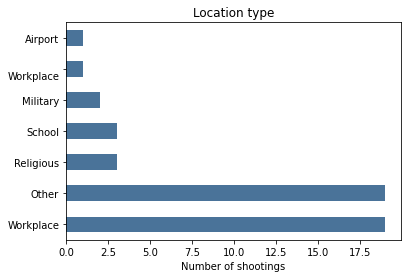

In [205]:
# Rename column location.1 to remove the dot
df.rename(columns={"location.1": "location1"}, inplace=True)
                   
df.location1.value_counts().plot(kind='barh',color='#4a7399')
plt.title('Location type')
plt.xlabel('Number of shootings')
plt.show()

In [206]:
# Check if the used weapons were obtained legally or not:
df.weapons_obtained_legally.value_counts().head()

Yes        25
TBD         7
-           6
No          4
Unknown     3
Name: weapons_obtained_legally, dtype: int64

As we can see, most weapons that were used in the shootings were legally obtained and licenced. It will be interesting later on to see if there is a correlation between this and how much the media speak of firearms after the event.

<AxesSubplot:ylabel='race'>

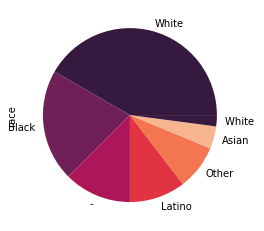

In [207]:
df.race.value_counts().plot(kind='pie',colors=sns.color_palette('rocket'))

Again, race of the shooter could be a possible covariate for the media covering of the shooting, and we will invesigate on this later on.

We are now interested in performing a linear regression analysis to study the bahavior of fatalities.  We would like to model the fatalities with two predictors : injured persons and age of the shooter. Our results could then help us understand better how medias are treating subjects according to number of death versus injured or the age of the shooter.

In [208]:
# Declares the model
mod = smf.ols(formula='fatalities ~ injured + age_of_shooter', data=df, missing = 'drop')

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             fatalities   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     31.45
Date:                Thu, 11 Nov 2021   Prob (F-statistic):           3.84e-09
Time:                        20:33:47   Log-Likelihood:                -154.29
No. Observations:                  46   AIC:                             314.6
Df Residuals:                      43   BIC:                             320.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.0035      3.509      3.

Firstly, we notice that age of shooter is not a significant predictor (p=0.1), but injured is (p=000). 
The model can be interpreted as fatalities = 12 + 0.11*injured -0.17* age_of_shooter

Finally, we will use this dataframe in comparitive plots in part 3. Therefore we save it to a new dataframe (in case we want to overwrite "df" further on):

In [233]:
data2 = df[['date','fatalities']]

## 4 - Linking the two datasets

We will start by plotting a single timeline graph with the number of fatalities due to shootings over time, as well as the occurence of gun-related words in the media.

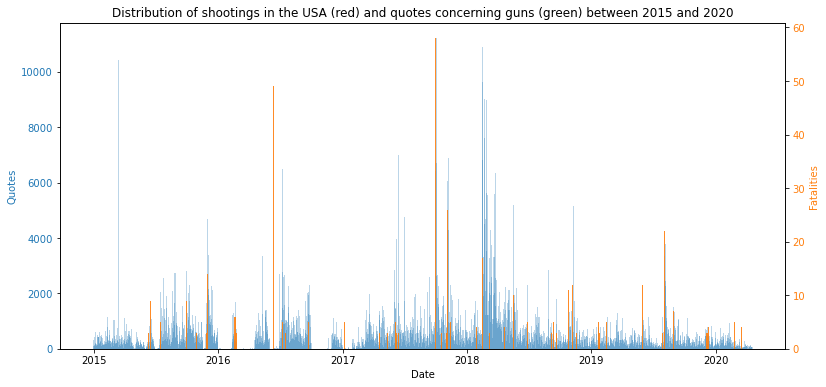

In [248]:
fig, ax1 = plt.subplots(figsize=(13,6))

# Plotting the quotes over time (green)
color = 'tab:blue'
ax1.set_title('Distribution of shootings in the USA (red) and quotes concerning guns (green) between 2015 and 2020')
ax1.set_xlabel('Date')
ax1.set_ylabel('Quotes', color=color)
ax1.bar(data1['date'], data1['numOccurrences'], color=color, alpha=0.3, width = 3)
ax1.tick_params(axis='y', labelcolor=color)

# Same x-axis, but different y axis
ax2 = ax1.twinx()

# Plotting the fatalities due to shootings over time (red)
color = 'tab:orange'
ax2.set_ylabel('Fatalities', color=color)  # we already handled the x-label with ax1
ax2.bar(data2['date'], data2['fatalities'], color=color, alpha=0.9, width = 3)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

We can see several interesting events in this first plot. For example, the largest peak in fatalities happens around october 2017. It is followed by the second largest peak in quotes talking about guns.

In [244]:
# Print the largest shooting (most fatalities)
data2 = data2.sort_values(by='fatalities',ascending=False)
data2 = data2.reset_index(drop=True)
print("The largest shooting was:")
print(data2.iloc[0])

# Quotes following the shooting (two days after)
data1 = data1.sort_values(by='numOccurrences',ascending=False)
print("\nThe corresponding peak in quotes discussing guns was:")
print(data1.iloc[1])

The largest shooting was:
date          2017-10-01 00:00:00
fatalities                     58
Name: 0, dtype: object

The corresponding peak in quotes discussing guns was:
date              2018-02-15 00:00:00
numOccurrences                  10888
Name: 1025, dtype: object


With the above print, we see that this peak is maximal exactly two days after the shooting.

### Correlation between mass shootings and number of quotes
First, we want to show that there is an association between the occurences of mass shootings (in orange) and the number of quotations in our subset (in blue). For this, we will test the correlation between the number of quotes in the subset and the number of days since the last shooting.

In [249]:
# We create a column to store the day of the last shooting
data1['DateLastShooting'] = np.nan

for index, row in data1.iterrows():
    row_date = row['date']
    past_shootings = data2[data2['date'] < row_date]
    last_shooting = np.max(past_shootings['date'])
    data1.at[index, 'DateLastShooting'] = last_shooting

# We create another column to count the number of days since the last shooting 
data1['DaysSinceLastShooting'] = (data1['date'] - data1['DateLastShooting']).dt.days
data1.head()

C:\Users\Doo\anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1342: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


date  numOccurrences     DateLastShooting  DaysSinceLastShooting
889  2017-10-02           11214  2017-10-01 00:00:00                    1.0
1025 2018-02-15           10888  2018-02-14 00:00:00                    1.0
74   2015-03-16           10435                  NaT                    NaN
1024 2018-02-14            9618  2018-01-28 00:00:00                   17.0
1031 2018-02-21            9006  2018-02-14 00:00:00                    7.0

In [250]:
from scipy.stats import stats
data1_filtered = data1.dropna()
stats.pearsonr(data1_filtered['DaysSinceLastShooting'], data1_filtered['numOccurrences'])

(-0.182646126853902, 6.765708511823923e-14)

We observe a highly significant **negative correlation** between the two variables. This was the expected result, since it shows that the more days since the last shooting, the less occurrences of quotes talking about guns and firearms. 

### Fatalities vs. Quotes count 
Another interesting observation we can make is that the largest peak in quotes concerning guns takes place after a smaller shooting, in early 2018:

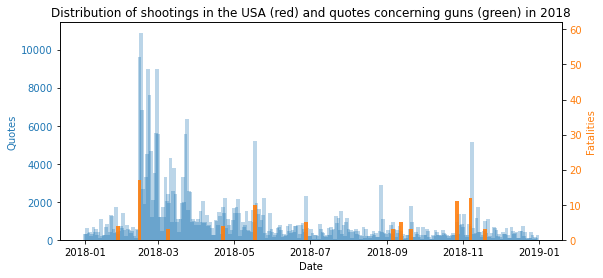

In [251]:
# We want to zoom in by looking only at 2018
data1_2018 = data1[(data1['date'].dt.year==2018)]
data2_2018 = data2[(data2['date'].dt.year==2018)]

fig, ax1 = plt.subplots(figsize=(9,4))

# Plotting the quotes over time (green barplot)
color = 'tab:blue'
ax1.set_title('Distribution of shootings in the USA (red) and quotes concerning guns (green) in 2018')
ax1.set_xlabel('Date')
ax1.set_ylabel('Quotes', color=color)
ax1.bar(data1_2018['date'], data1_2018['numOccurrences'], color=color, alpha=0.3, width = 3)
ax1.tick_params(axis='y', labelcolor=color)

# Same x-axis, but different y axis
ax2 = ax1.twinx()

# Plotting the fatalities due to shootings over time (red barplot)
color = 'tab:orange'
ax2.set_ylabel('Fatalities', color=color)  # we already handled the x-label with ax1
ax2.bar(data2_2018['date'], data2_2018['fatalities'], color=color, alpha=0.9, width = 3)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,62)

plt.show()

It seams that this particular event has made much more noise then the others and over a larger period of time. The fact that it was **certainly not the shooting with the most fatalities** ("only" 17, compared to 58 for the max) shows that the number of fatalities is clearly not the only parameter that influences the media coverage of the event as well as the amplitude of the discussion on gun control afterwards.

**This makes us want to investigate further: what are the other factors that can explain these differences?** Some ideas: 
- Location of the shooting (what state, but also what type of place: e.g. at a school, workplace...)
- Wheather of not the weapon was bought legally
- Age, gender and ethnicity of the shooter and/or the victims
- The type of weapon that was used
- etc.

**Selecting the timeframe following each shooting**<br>
In order to analyse the media's response to each shooting, we can start by selecting only the quotes from the following N days (for the moment we chose N=10). We did this for the top 3 most lethal shootings and plotted the results below. These again emphasize the idea that there is much more than just the number of fatalities.

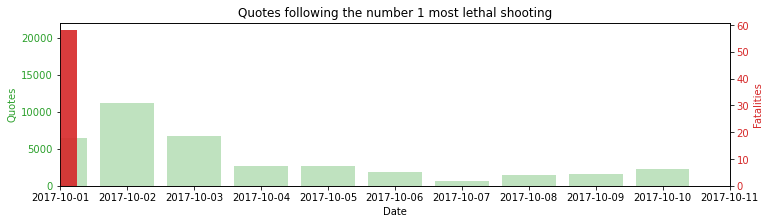

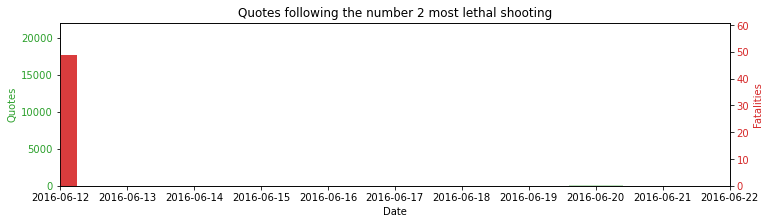

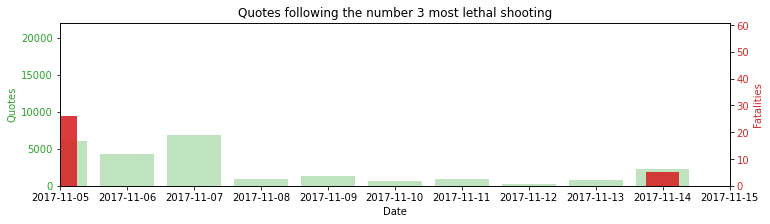

In [246]:
# We want to zoom in for the 10 days after each shooting
from datetime import timedelta

for i in range(0,3):
    
    # Get the date of the (i+1)th most lethal shooting
    shooting_date = data2.sort_values(by='fatalities',ascending=False)['date'].iloc[i]
    
    # Select only the quotes in the 10 days following the selected shooting
    shooting_after =  data1[((data1['date'] >= shooting_date))]
    shooting_after =  shooting_after[(shooting_after['date'] < shooting_date + timedelta(days=10))]

    fig, ax1 = plt.subplots(figsize=(12,3))
    
    # Plotting the quotes over time (green barplot)
    color = 'tab:green'
    ax1.set_title('Quotes following the number ' + str(i+1) + ' most lethal shooting')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Quotes', color=color)
    ax1.bar(shooting_after['date'], shooting_after['numOccurrences'], color=color, alpha=0.3, width = 0.8)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlim(shooting_date,shooting_date+ timedelta(days=10))
    ax1.set_ylim(0,22000)
    
    # Same x-axis, but different y axis
    ax2 = ax1.twinx()
    
    # Plotting the fatalities due to shootings over time (red barplot)
    color = 'tab:red'
    ax2.set_ylabel('Fatalities', color=color)  # we already handled the x-label with ax1
    ax2.bar(data2['date'], data2['fatalities'], color=color, alpha=0.9, width = 0.5)
    ax2.tick_params(axis='y', labelcolor=color)

plt.show()

Just to give us an idea, we can look at the corresponding case in the dataframe and get all the details we know about it:

In [178]:
df = df[(df['date'].dt.year==2018)]
df = df.sort_values(by='fatalities', ascending=False)
df.iloc[0]

case                                    Marjory Stoneman Douglas High School shooting
location                                                            Parkland, Florida
date                                                              2018-02-14 00:00:00
summary                             Nikolas J. Cruz, 19, heavily armed with an AR-...
fatalities                                                                         17
injured                                                                            17
total_victims                                                                      34
location1                                                                      School
age_of_shooter                                                                     19
prior_signs_mental_health_issues                                                  Yes
mental_health_details               Cruz had a long history of behavioral problems...
weapons_obtained_legally                              

Our final goal would be to have a single value (or score) that represents the media's reaction to each event. For example, a score of 1 would be maximal reaction, and a score of 0 would be no reaction. We could then **use linear regression to find how each parameter influences the reaction score**: location, age/gender/ethnicity of shooter, gun legality... We could have this score based on the slope of the number of quotes after the shooting. **How could we compute this score?**

Another possibility for analysis is to look at the political positionning of the speakers and/or news sources for the quotes. We could see if some type of shootings make more democrats/republicans talk about it (i.e. if there is a correlation between policial views and topic covering).

If there is an equilibrium between the coverage on both sides, then it is likely that the reaction of the media can be considered as important, as everyone is talking about it.